## An overview to the Realtime drowsiness detection program

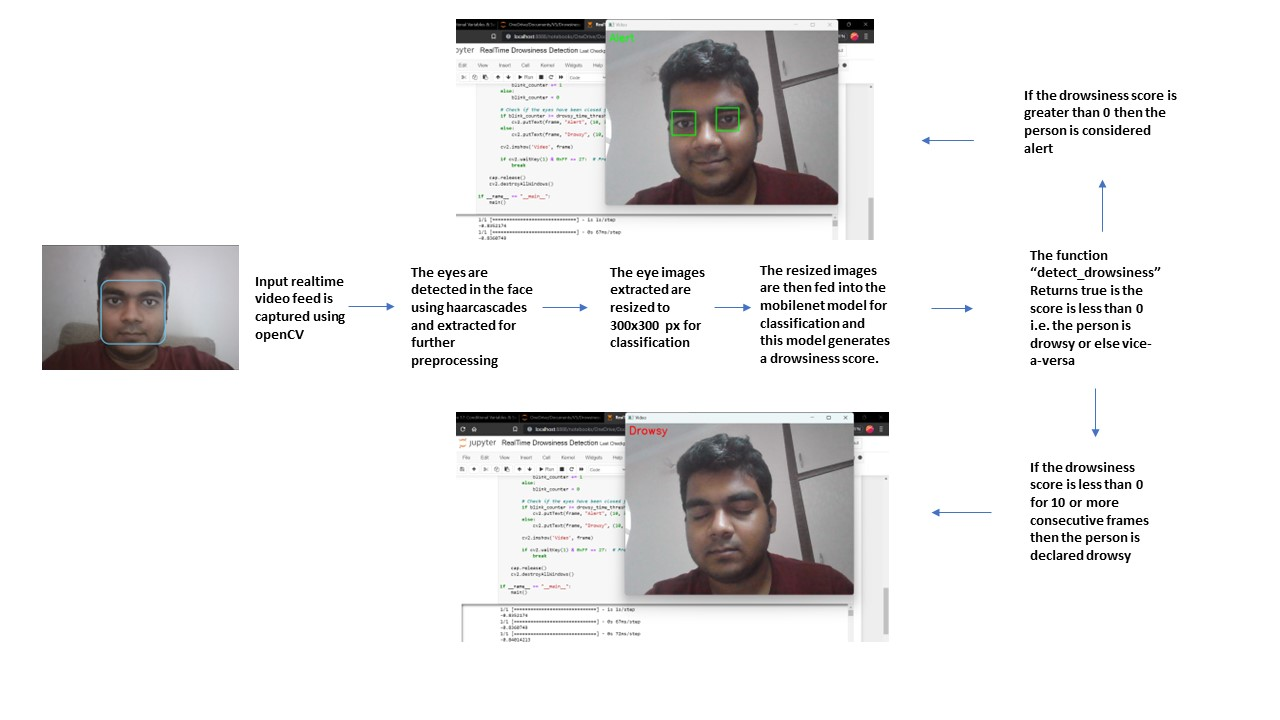

#### Importing the necessary libraries

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

## Let's understand each function in depth

#### 1. Function to detect eyes

In [ ]:
def detect_eyes(frame, face_cascade, eye_cascade):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

    eyes_coordinates = []
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)

        for (ex, ey, ew, eh) in eyes:
            eye_roi = frame[y:y+h, x:x+w]
            eyes_coordinates.append((x + ex, y + ey, ew, eh))

    return eyes_coordinates

#### This function detects the eyes using the HaarCascades in the captured image from real-time video feed and returns the coordinates of the eyes 

#### 2. Function to classify the images 

In [ ]:
def detect_drowsiness(model, eye):
    eye_resized = cv2.resize(eye, (300,300))
    eye_resized = eye_resized.astype(np.float32) / 255.0
    eye_resized = np.expand_dims(eye_resized, axis=0)

    prediction = model.predict(eye_resized)

    drowsiness_score = prediction[0][0]
    print(drowsiness_score)
    if drowsiness_score<0:
        return True
    else:
        return False

#### This function utilizes the pretrained model stored in the same directory to classify if the person is drowsy or not. It receives the model and the images of the eyes as parameters.
#### It then resizes the images into 300 * 300 px and then converts it to B/W images for classification
#### The processed images are then fed into the model to generate a drowsiness score and returns True if the score <0 i.e. the preson is drowsy or else vice-a-versa

### 3. The main function

In [ ]:
def main():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    # import the haarCascades for face detection and eye detection

    model = tf.keras.models.load_model("model") # Load the model

    cap = cv2.VideoCapture(0)

    blink_counter = 0 
    drowsy_time_threshold = 10  #will classify drowsy if eyes closed for more than 10 frames
    drowsy = False

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        eyes_coordinates = detect_eyes(frame, face_cascade, eye_cascade) #Get the coordinates of the eyes in the Live-Feed

        drowsy_count = 0
        for (ex, ey, ew, eh) in eyes_coordinates:
            eye = frame[ey:ey+eh, ex:ex+ew]

            drowsy = detect_drowsiness(model, eye)

            if drowsy:
                color = (0, 255, 0)  # Red color for drowsy eyes
                drowsy_count += 1
            else:
                color = (0, 0, 255)  # Green color for alert eyes

            # For drawing a rectangle around the detected eyes
            cv2.rectangle(frame, (ex, ey), (ex + ew, ey + eh), color, 2)

        if drowsy_count > 0:
            blink_counter += 1
        else:
            blink_counter = 0

        # Check if the eyes have been closed for a long time 
        if blink_counter >= drowsy_time_threshold:
            cv2.putText(frame, "Alert", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        else:
            cv2.putText(frame, "Drowsy", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        cv2.imshow('Video', frame)

        if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

#### The main function captures the live video using openCV library and detect eyes using the "detect_eyes" function and then invokes the function "detect_drowsiness" to detect if the person is alert or not.
#### If the person is not alert for 10 frames then the person is drowsy and the same is written on the screen.